## IMPORTS

In [1]:
import numpy as np
import pandas as pd 
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

## EDA

In [2]:
df = pd.read_csv("data/raw/pretransformed_heart_disease.csv")
df.head()

,Age (in years),Sex,Chest pain type,Resting blood pressure (in mm Hg on admission to the hospital),Serum cholesterol (in mg/dl),Fasting blood sugar > 120 mg/dl,Resting electrocardiographic results,Maximum heart rate achieved,Exercise-induced angina,ST depression induced by exercise relative to rest,Slope of the peak exercise ST segment,Number of major vessels (0–3) colored by fluoroscopy,Thalassemia,Diagnosis of heart disease
0,63,male,typical angina,145,233,True,showing probable or definite left ventricular ...,150,no,2.3,downsloping,0.0,fixed defect,< 50% diameter narrowing
1,67,male,asymptomatic,120,229,False,showing probable or definite left ventricular ...,129,yes,2.6,flat,2.0,reversable defect,> 50% diameter narrowing
2,37,male,non-anginal pain,130,250,False,normal,187,no,3.5,downsloping,0.0,normal,< 50% diameter narrowing
3,41,female,atypical angina,130,204,False,showing probable or definite left ventricular ...,172,no,1.4,upsloping,0.0,normal,< 50% diameter narrowing
4,56,male,atypical angina,120,236,False,normal,178,no,0.8,upsloping,0.0,normal,< 50% diameter narrowing


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 14 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Age (in years)                                                  219 non-null    int64  
 1   Sex                                                             219 non-null    object 
 2   Chest pain type                                                 219 non-null    object 
 3   Resting blood pressure (in mm Hg on admission to the hospital)  219 non-null    int64  
 4   Serum cholesterol (in mg/dl)                                    219 non-null    int64  
 5   Fasting blood sugar > 120 mg/dl                                 219 non-null    bool   
 6   Resting electrocardiographic results                            219 non-null    object 
 7   Maximum heart rate achieved                          

In [4]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [5]:
numeric_columns = [
    'age_(in_years)', 
    'resting_blood_pressure_(in_mm_hg_on_admission_to_the_hospital)', 
    'serum_cholesterol_(in_mg/dl)', 
    'maximum_heart_rate_achieved'
]

pair_plots = []
for x_col, y_col in itertools.combinations(numeric_columns, 2):
    chart = alt.Chart(df).mark_circle(size=60).encode(
        alt.X(f'{x_col}:Q', title=x_col.replace("_", " ").capitalize()),
        alt.Y(f'{y_col}:Q', title=y_col.replace("_", " ").capitalize()),
        color='diagnosis_of_heart_disease:N',
        tooltip=[x_col, y_col, 'diagnosis_of_heart_disease']
    ).properties(
        width=200,
        height=200
    )
    pair_plots.append(chart)

pair_plot_grid = alt.vconcat(*[
    alt.hconcat(*pair_plots[i:i + len(numeric_columns) - 1])
    for i in range(0, len(pair_plots), len(numeric_columns) - 1)
])

pair_plot_grid


alt.VConcatChart(...)

In [6]:
# Age distribution
age_dist = alt.Chart(df).mark_bar().encode(
    alt.X('age_(in_years):Q', bin=True, title="Age (Years)"),
    alt.Y('count()', title="Count"),
    tooltip=['count()']
).properties(
    title="Age Distribution",
    width=400,
    height=300
)

age_dist


alt.Chart(...)

In [7]:
# Diagnosis of Heart Disease
diagnosis_sex = alt.Chart(df).mark_bar().encode(
    alt.X('diagnosis_of_heart_disease:N', title="Heart Disease Diagnosis", axis=alt.Axis(labelAngle=0)),
    alt.Y('count()', title="Count"),
    color='sex:N',
    tooltip=['count()', 'sex']
).properties(
    title="Heart Disease Diagnosis by Sex",
    width=400,
    height=300
)

diagnosis_sex

alt.Chart(...)

In [8]:
# Resting Blood Pressure Distribution
resting_bp = alt.Chart(df).mark_bar().encode(
    alt.X('resting_blood_pressure_(in_mm_hg_on_admission_to_the_hospital):Q', bin=True, title="Resting Blood Pressure (mm Hg)"),
    alt.Y('count()', title="Count"),
    tooltip=['count()']
).properties(
    title="Resting Blood Pressure Distribution",
    width=400,
    height=300
)

resting_bp

alt.Chart(...)

In [9]:
# 4. Cholesterol Levels by Sex
cholesterol_sex = alt.Chart(df).mark_boxplot().encode(
    alt.X('sex:N', title="Sex"),
    alt.Y('serum_cholesterol_(in_mg/dl):Q', title="Cholesterol (mg/dl)"),
    color='sex:N',
    tooltip=['serum_cholesterol_(in_mg/dl)', 'sex']
).properties(
    title="Cholesterol Levels by Sex",
    width=400,
    height=300
)

cholesterol_sex


alt.Chart(...)

In [10]:
# 5. Maximum Heart Rate Distribution
heart_rate = alt.Chart(df).mark_bar().encode(
    alt.X('maximum_heart_rate_achieved:Q', bin=True, title="Maximum Heart Rate"),
    alt.Y('count()', title="Count"),
    tooltip=['count()']
).properties(
    title="Maximum Heart Rate Distribution",
    width=400,
    height=300
)

heart_rate


alt.Chart(...)

In [11]:
# 6. Diagnosis by Chest Pain Type
chest_pain_diag = alt.Chart(df).mark_bar().encode(
    alt.X('chest_pain_type:N', title="Chest Pain Type", axis=alt.Axis(labelAngle=0)),
    alt.Y('count()', title="Count"),
    color='diagnosis_of_heart_disease:N',
    tooltip=['count()', 'chest_pain_type', 'diagnosis_of_heart_disease']
).properties(
    title="Heart Disease Diagnosis by Chest Pain Type",
    width=400,
    height=300
)

chest_pain_diag



alt.Chart(...)

In [12]:
# 7. ST Depression by Diagnosis
st_depression = alt.Chart(df).mark_boxplot().encode(
    alt.X('diagnosis_of_heart_disease:N', title="Heart Disease Diagnosis", axis=alt.Axis(labelAngle=0)),
    alt.Y('st_depression_induced_by_exercise_relative_to_rest:Q', title="ST Depression"),
    color='diagnosis_of_heart_disease:N',
    tooltip=['st_depression_induced_by_exercise_relative_to_rest', 'diagnosis_of_heart_disease']
).properties(
    title="ST Depression by Diagnosis",
    width=400,
    height=300
)

st_depression

alt.Chart(...)

In [13]:
# 8. Number of Major Vessels by Chest Pain Type
vessels_chest_pain = alt.Chart(df).mark_boxplot().encode(
    alt.X('chest_pain_type:N', title="Chest Pain Type"),
    alt.Y('number_of_major_vessels_(0–3)_colored_by_fluoroscopy:Q', title="Number of Major Vessels"),
    color='chest_pain_type:N',
    tooltip=['number_of_major_vessels_(0–3)_colored_by_fluoroscopy', 'chest_pain_type']
).properties(
    title="Number of Major Vessels by Chest Pain Type",
    width=400,
    height=300
)

vessels_chest_pain


alt.Chart(...)

In [14]:
# 9. Diagnosis Distribution
diagnosis_dist = alt.Chart(df).mark_bar().encode(
    alt.X('diagnosis_of_heart_disease:N', title="Heart Disease Diagnosis", axis=alt.Axis(labelAngle=0)),
    alt.Y('count()', title="Count"),
    color='diagnosis_of_heart_disease:N',
    tooltip=['count()']
).properties(
    title="Heart Disease Diagnosis Distribution",
    width=400,
    height=300
)

diagnosis_dist


alt.Chart(...)

## ML-analysis (code)

In [15]:
# Import modules
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
 
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split

In [16]:
#Import data
data = pd.read_csv('data/raw/pretransformed_heart_disease.csv')
data.head()

,Age (in years),Sex,Chest pain type,Resting blood pressure (in mm Hg on admission to the hospital),Serum cholesterol (in mg/dl),Fasting blood sugar > 120 mg/dl,Resting electrocardiographic results,Maximum heart rate achieved,Exercise-induced angina,ST depression induced by exercise relative to rest,Slope of the peak exercise ST segment,Number of major vessels (0–3) colored by fluoroscopy,Thalassemia,Diagnosis of heart disease
0,63,male,typical angina,145,233,True,showing probable or definite left ventricular ...,150,no,2.3,downsloping,0.0,fixed defect,< 50% diameter narrowing
1,67,male,asymptomatic,120,229,False,showing probable or definite left ventricular ...,129,yes,2.6,flat,2.0,reversable defect,> 50% diameter narrowing
2,37,male,non-anginal pain,130,250,False,normal,187,no,3.5,downsloping,0.0,normal,< 50% diameter narrowing
3,41,female,atypical angina,130,204,False,showing probable or definite left ventricular ...,172,no,1.4,upsloping,0.0,normal,< 50% diameter narrowing
4,56,male,atypical angina,120,236,False,normal,178,no,0.8,upsloping,0.0,normal,< 50% diameter narrowing


In [17]:
# Transform target column to True/False with new label of 
# '> 50% diameter narrowing'

data['Diagnosis of heart disease'] = data['Diagnosis of heart disease'].replace({'< 50% diameter narrowing': False, '> 50% diameter narrowing': True})
data.rename(columns={'Diagnosis of heart disease': '> 50% diameter narrowing'}, inplace=True)
data.head()

C:\Users\nguye\AppData\Local\Temp\ipykernel_39752\948054868.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Diagnosis of heart disease'] = data['Diagnosis of heart disease'].replace({'< 50% diameter narrowing': False, '> 50% diameter narrowing': True})


,Age (in years),Sex,Chest pain type,Resting blood pressure (in mm Hg on admission to the hospital),Serum cholesterol (in mg/dl),Fasting blood sugar > 120 mg/dl,Resting electrocardiographic results,Maximum heart rate achieved,Exercise-induced angina,ST depression induced by exercise relative to rest,Slope of the peak exercise ST segment,Number of major vessels (0–3) colored by fluoroscopy,Thalassemia,> 50% diameter narrowing
0,63,male,typical angina,145,233,True,showing probable or definite left ventricular ...,150,no,2.3,downsloping,0.0,fixed defect,False
1,67,male,asymptomatic,120,229,False,showing probable or definite left ventricular ...,129,yes,2.6,flat,2.0,reversable defect,True
2,37,male,non-anginal pain,130,250,False,normal,187,no,3.5,downsloping,0.0,normal,False
3,41,female,atypical angina,130,204,False,showing probable or definite left ventricular ...,172,no,1.4,upsloping,0.0,normal,False
4,56,male,atypical angina,120,236,False,normal,178,no,0.8,upsloping,0.0,normal,False


In [18]:
train_df, test_df = train_test_split(data, test_size=0.1)

X_train = train_df.drop('> 50% diameter narrowing', axis=1)
y_train = train_df['> 50% diameter narrowing']
X_test = test_df.drop('> 50% diameter narrowing', axis=1)
y_test = test_df['> 50% diameter narrowing']

In [19]:
# Lists of feature names
categorical_features = ['Sex', 
                        'Chest pain type', 
                        'Fasting blood sugar > 120 mg/dl', 
                        'Resting electrocardiographic results', 
                        'Exercise-induced angina', 
                        'Slope of the peak exercise ST segment', 
                        'Thalassemia']
numeric_features = list(set(X_train.columns) - set(categorical_features))

# Create transformer pipeline
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", drop='if_binary', dtype=int, sparse_output=False),
)

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median", fill_value="missing"),
    StandardScaler(),
)

# Create the column transformer
preprocessor = make_column_transformer(
    (categorical_transformer, categorical_features),
    (numeric_transformer, numeric_features),
)
# Show the preprocessor
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Chest pain type',
                                  'Fasting blood sugar > 120 mg/dl',
                                  'Resting electrocardiographic results',
                                  'Exer...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Serum cholesterol (in mg/dl)',
                                  'Resting blood pressure (in mm Hg on '
                                  'admission to the hospital)',
                                  'ST depression induced by exercise relative '
                                  'to rest',
                                  'Age (in years)',
                                  'Number of major vessels (0–3) colored by '
                                  'fluoroscopy',
                                  'Maximum heart rate achieved'])])

In [20]:
# 0. Dummy model
# Imports
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (make_scorer, 
                            precision_score,
                            recall_score,
                            f1_score)

classification_metrics = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, pos_label=True),
    "recall": make_scorer(recall_score, pos_label=True),
    "f1": make_scorer(f1_score, pos_label=True),
}

# The dummy model
dc = make_pipeline(preprocessor, DummyClassifier())
# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results = {}
cross_val_results['dummy'] = pd.DataFrame(cross_validate(dc, 
                                                         X_train, 
                                                         y_train, 
                                                         cv=5, 
                                                         scoring=classification_metrics,
                                                         )).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['dummy']

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Pre

,mean,std
fit_time,0.007,0.001
score_time,0.007,0.001
test_accuracy,0.741,0.009
test_precision,0.000,0.000
test_recall,0.000,0.000
test_f1,0.000,0.000


In [21]:
# 1. Logistic Regression model

# The logreg model pipeline
logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=1000))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['logreg'] = pd.DataFrame(cross_validate(logreg, 
                                                          X_train, 
                                                          y_train, 
                                                          cv=5, 
                                                          scoring=classification_metrics, 
                                                          return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg'] 

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,mean,std
fit_time,0.008,0.005
score_time,0.009,0.003
test_accuracy,0.817,0.045
train_accuracy,0.836,0.024
test_precision,0.725,0.124
train_precision,0.758,0.055
test_recall,0.493,0.084
train_recall,0.540,0.055
test_f1,0.583,0.090
train_f1,0.630,0.055


In [22]:
# 2. Support vector classifier
# Imports
from sklearn.svm import SVC

# The svc model pipeline
svc = make_pipeline(preprocessor, SVC(random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['svc'] = pd.DataFrame(cross_validate(svc, 
                                                      X_train, 
                                                      y_train, 
                                                      cv=5, 
                                                      scoring=classification_metrics, 
                                                      return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['svc'] 

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,mean,std
fit_time,0.009,0.004
score_time,0.007,0.002
test_accuracy,0.792,0.021
train_accuracy,0.887,0.008
test_precision,0.753,0.152
train_precision,0.960,0.002
test_recall,0.313,0.028
train_recall,0.588,0.033
test_f1,0.438,0.028
train_f1,0.729,0.025


C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


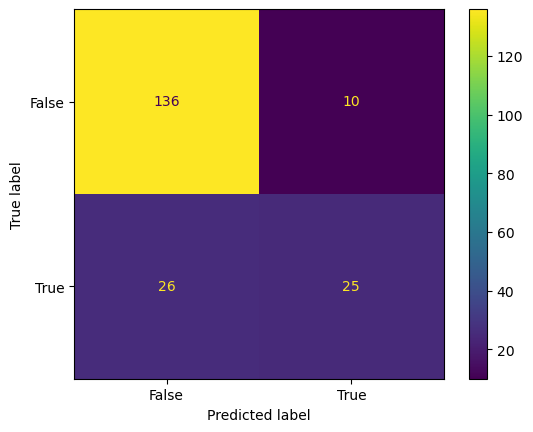

In [23]:
# 3. Confusion matrix for the logistic regression
# Imports
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

confmat_logreg = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(logreg, X_train, y_train),
    values_format='d'
)
# Show the matrix
confmat_logreg

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


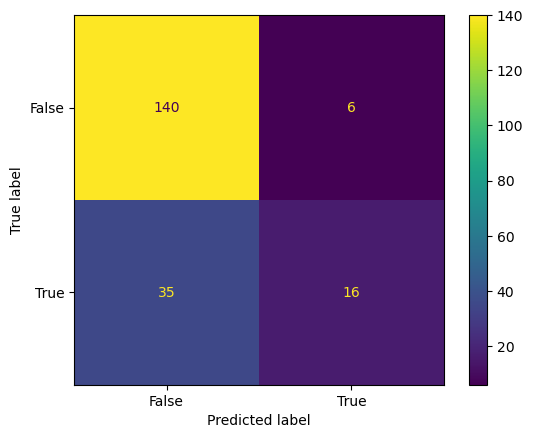

In [24]:
# 3. Confusion matrix for the SVC
confmat_svc = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(svc, X_train, y_train),
    values_format='d',
)
# Show the matrix
confmat_svc

In [25]:
# 4. Balanced logistic regression
# The logreg model pipeline
logreg_bal = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=1000, class_weight="balanced"))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['logreg_bal'] = pd.DataFrame(cross_validate(logreg_bal, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=5, 
                                                        scoring=classification_metrics,
                                                        return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg_bal'] 

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,mean,std
fit_time,0.009,0.001
score_time,0.007,0.001
test_accuracy,0.731,0.044
train_accuracy,0.801,0.021
test_precision,0.488,0.051
train_precision,0.587,0.033
test_recall,0.687,0.076
train_recall,0.789,0.028
test_f1,0.570,0.057
train_f1,0.673,0.027


In [26]:
# 5. Balanced support vector classifier
# The svc model pipeline
svc_bal = make_pipeline(preprocessor, SVC(random_state=123, class_weight="balanced"))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['svc_bal'] = pd.DataFrame(cross_validate(svc_bal, 
                                                          X_train, 
                                                          y_train, 
                                                          cv=5, 
                                                          scoring=classification_metrics, 
                                                          return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['svc_bal'] 

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,mean,std
fit_time,0.009,0.001
score_time,0.008,0.000
test_accuracy,0.716,0.039
train_accuracy,0.906,0.005
test_precision,0.461,0.062
train_precision,0.760,0.012
test_recall,0.589,0.103
train_recall,0.931,0.021
test_f1,0.516,0.072
train_f1,0.837,0.008


C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


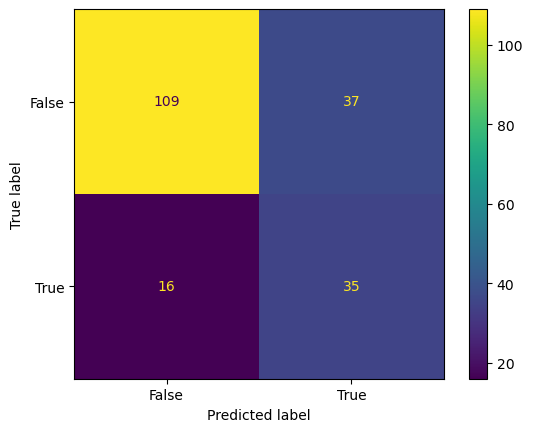

In [27]:
# 6. Confusion matrix for the balanced logistic regression

confmat_logreg_bal = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(logreg_bal, X_train, y_train),
    values_format='d'
)
# Show the matrix
confmat_logreg_bal

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


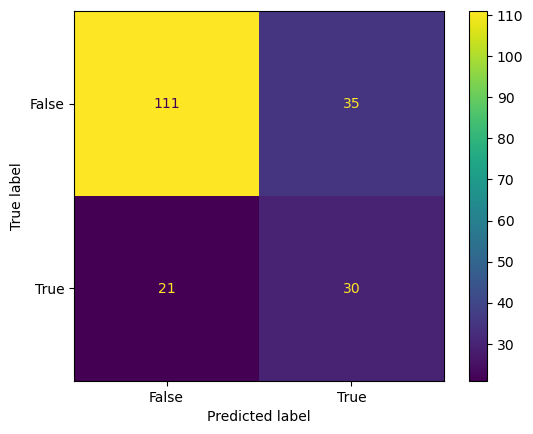

In [28]:
# 6. Confusion matrix for the balanced SVC
confmat_svc_bal = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(svc_bal, X_train, y_train),
    values_format='d'
)
# Show the matrix
confmat_svc_bal

In [29]:
# Manual check that the cross val std doesn't look way off for some model
pd.concat(
    cross_val_results,
    axis='columns'  # Get the right model names and mean/std as columns
).xs(
    'std',  # Select only the 'std' columns
    axis='columns',  # Cross-section the columns
    level=1  # The 1st level ('mean', 'std') instead of the 0th level (the model names)
).style.format(
    precision=2  # Pandas `.style` does not honor previous rounding via `.round()`
).background_gradient(
    axis=None  # Color cells based on the entire matrix rather than row/column-wise
)

,dummy,logreg,svc,logreg_bal,svc_bal
fit_time,0.00,0.01,0.00,0.00,0.00
score_time,0.00,0.00,0.00,0.00,0.00
test_accuracy,0.01,0.04,0.02,0.04,0.04
test_precision,0.00,0.12,0.15,0.05,0.06
test_recall,0.00,0.08,0.03,0.08,0.10
test_f1,0.00,0.09,0.03,0.06,0.07
train_accuracy,nan,0.02,0.01,0.02,0.01
train_precision,nan,0.06,0.00,0.03,0.01
train_recall,nan,0.06,0.03,0.03,0.02
train_f1,nan,0.06,0.03,0.03,0.01


In [30]:
# Compare the average scores of all the models
pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=2
).background_gradient(
    axis=None
)

,dummy,logreg,svc,logreg_bal,svc_bal
fit_time,0.01,0.01,0.01,0.01,0.01
score_time,0.01,0.01,0.01,0.01,0.01
test_accuracy,0.74,0.82,0.79,0.73,0.72
test_precision,0.00,0.72,0.75,0.49,0.46
test_recall,0.00,0.49,0.31,0.69,0.59
test_f1,0.00,0.58,0.44,0.57,0.52
train_accuracy,nan,0.84,0.89,0.80,0.91
train_precision,nan,0.76,0.96,0.59,0.76
train_recall,nan,0.54,0.59,0.79,0.93
train_f1,nan,0.63,0.73,0.67,0.84


# Comparing the metrics across models
## Balanced logistic regression yields the highest recall and with second to the highest f1_score. For this report, we choose to proceed with `LogisticRegression(class_weight="balanced")` and optimize the f1 score metric along with optimizing recall as we want to minimize False Negatives, which is more damaging in medical diagnosis than False Positives

In [31]:
# Hyperparameter optimization f1
import numpy as np

# Define parameter distributions
param_distributions = {
    'logisticregression__C': np.logspace(-5, 5, 50),  # Regularization strength
}

random_search = RandomizedSearchCV(logreg_bal, param_distributions=param_distributions,  
                                    n_iter=100, n_jobs= -1,
                                    scoring='f1',
                                    return_train_score=True,
                                    random_state=123)

random_search.fit(X_train, y_train)

C:\Users\nguye\miniforge3\envs\573\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              dtype=<class 'int'>,
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Sex',
                                                                                'Chest '
                                                                                'pain '
                                                                                'type',
                                                                                '...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
                   random_state=123, return_train_score=True, scoring='f1')

In [32]:
# Extract cv_results_ into a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.sort_values(by='rank_test_score').head(3)
top_results = top_results[[
    'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'params', 
]]

# Set pandas options to display all column content
pd.set_option('display.max_colwidth', None)
top_results

,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,params
21,0.657248,0.023607,0.604951,0.029918,0.018671,{'logisticregression__C': 0.19306977288832497}
19,0.645224,0.016088,0.601510,0.043226,0.015497,{'logisticregression__C': 0.07543120063354623}
20,0.653919,0.015481,0.600644,0.036832,0.014478,{'logisticregression__C': 0.1206792640639329}


# Add  this to the analysis
The hyperparameter optimization made a difference **('mean_test_score' (0.58) compared to 'mean_test_score of cross' (0.54) of previous mean validation score)**. However, the cross-validation scores among the top three models are approximately equivalent. This suggests that the model's performance is relatively stable across the parameter space, indicating that further tuning may not yield substantial improvements.

In [33]:
# Fit and predict the test dataset with our best model
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Chest pain type',
                                                   'Fasting blood sugar > 120 '
                                                   'mg/dl',
                                                   'Re...
                                                  ['Serum cholesterol (in '
                                                   'mg/dl)',
                                                   'Resting blood pressure (in '
                                                   'mm Hg on admission to the '
                                                   'hospital)',
                                                   'ST depression induced by '
                                                   'exercise relative to rest',
                                                   'Age (in years)',
                                                   'Number of major vessels '
                                                   '(0–3) colored by '
                                                   'fluoroscopy',
                                                   'Maximum heart rate '
                                                   'achieved'])])),
                ('logisticregression',
                 LogisticRegression(C=0.19306977288832497,
                                    class_weight='balanced', max_iter=1000,
                                    random_state=123))])

In [34]:
# f1_score Metrics
from sklearn.metrics import f1_score

# Predict labels for train and test sets
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Compute precision explicitly
train_f1 = f1_score(y_train, train_predictions, average='binary')
test_f1 = f1_score(y_test, test_predictions, average='binary')

print("Random Search best model f1_score: %0.3f" % random_search.best_score_)
print("Train f1_score on the full train set: %0.3f" % train_f1)
print("Test f1_score on the full test set: %0.3f" % test_f1)

Random Search best model f1_score: 0.605
Train f1_score on the full train set: 0.655
Test f1_score on the full test set: 0.545


In [35]:
# recall Metrics
from sklearn.metrics import recall_score

# Compute precision explicitly
train_recall = recall_score(y_train, train_predictions, average='binary')
test_recall = recall_score(y_test, test_predictions, average='binary')

print("Train recall on the full train set: %0.3f" % train_recall)
print("Test recall on the full test set: %0.3f" % test_recall)

Train recall on the full train set: 0.745
Test recall on the full test set: 0.750


In [36]:
# Accuracy Metrics
random_search_best_score = random_search.best_score_
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
...

print("Train score on the full train set: %0.3f" % train_score)
print("Test score on the full test set: %0.3f" % test_score)

Train score on the full train set: 0.797
Test score on the full test set: 0.773


## Written analysis

In [37]:
#Title


In [38]:
#summary

In [39]:
#Methods / results

In [40]:
#Discussion

In [41]:
#References